In [1]:
#config
import torch
BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms
NUM_EPOCHS = 25 # number of epochs to train for
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# training images and XML files directory
TRAIN_DIR = '//hd.ad.syr.edu/02/8fe522/Documents/Desktop/BCCD/train'
# validation images and XML files directory
VALID_DIR = '//hd.ad.syr.edu/02/8fe522/Documents/Desktop/BCCD/test'
# classes: 0 index is reserved for background
CLASSES = [
    'background', 'RBC', 'WBC', 'Platelets'
]
NUM_CLASSES = 4
# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False
# location to save model and plots
OUT_DIR = r'\\hd.ad.syr.edu\02\8fe522\Documents\Desktop\outputs'
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs

In [2]:
#utils
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
#from config import DEVICE, CLASSES as classes

# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

In [3]:
#datasets 
import torch
import cv2
import numpy as np
import os
import glob as glob
from math import ceil, floor
from xml.etree import ElementTree as et
#from config import CLASSES, RESIZE_TO, TRAIN_DIR, VALID_DIR, BATCH_SIZE
from torch.utils.data import Dataset, DataLoader
#from utils import collate_fn, get_train_transform, get_valid_transform

# the dataset class
class MicrocontrollerDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split("/"  )[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_name = (image_name.split('\\' ))[-1]
        image_path = self.dir_path + '/' + image_name
        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height
            
            xmin_final = floor(xmin_final)
            ymin_final = floor(ymin_final)
            xmax_final = ceil(xmax_final)
            ymax_final = ceil(ymax_final)

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target
    def __len__(self):
        return len(self.all_images)
    
# prepare the final datasets and data loaders
train_dataset = MicrocontrollerDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_dataset = MicrocontrollerDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 219
Number of validation samples: 145



In [4]:
#model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [5]:
#engine
#from config import DEVICE, NUM_CLASSES, NUM_EPOCHS, OUT_DIR
#from config import VISUALIZE_TRANSFORMED_IMAGES
#from config import SAVE_PLOTS_EPOCH, SAVE_MODEL_EPOCH
#from model import create_model
#from utils import Averager
from tqdm.auto import tqdm
#from datasets import train_loader, valid_loader
import torch
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

C:\Users\bsleight\AppData\Roaming\Python\Python37\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\bsleight\AppData\Roaming\Python\Python37\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



EPOCH 1 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #0 train loss: 1.209
Epoch #0 validation loss: 2.680
Took 49.130 minutes for epoch 0

EPOCH 2 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #1 train loss: 0.757
Epoch #1 validation loss: 0.895
Took 48.886 minutes for epoch 1
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 3 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #2 train loss: 0.614
Epoch #2 validation loss: 0.712
Took 50.755 minutes for epoch 2

EPOCH 4 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #3 train loss: 0.564
Epoch #3 validation loss: 0.640
Took 46.411 minutes for epoch 3
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 5 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #4 train loss: 0.551
Epoch #4 validation loss: 0.640
Took 46.812 minutes for epoch 4

EPOCH 6 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #5 train loss: 0.544
Epoch #5 validation loss: 0.623
Took 46.547 minutes for epoch 5
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 7 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #6 train loss: 0.532
Epoch #6 validation loss: 0.605
Took 46.628 minutes for epoch 6

EPOCH 8 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #7 train loss: 0.528
Epoch #7 validation loss: 0.609
Took 46.683 minutes for epoch 7
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 9 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #8 train loss: 0.519
Epoch #8 validation loss: 0.589
Took 46.585 minutes for epoch 8

EPOCH 10 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #9 train loss: 0.518
Epoch #9 validation loss: 0.596
Took 46.439 minutes for epoch 9
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 11 of 25
Validating


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #10 train loss: 0.517
Epoch #10 validation loss: 0.594
Took 46.892 minutes for epoch 10

EPOCH 12 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #11 train loss: 0.503
Epoch #11 validation loss: 0.597
Took 46.967 minutes for epoch 11
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 13 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #12 train loss: 0.497
Epoch #12 validation loss: 0.597
Took 47.049 minutes for epoch 12

EPOCH 14 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #13 train loss: 0.496
Epoch #13 validation loss: 0.604
Took 48.486 minutes for epoch 13
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 15 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #14 train loss: 0.495
Epoch #14 validation loss: 0.583
Took 46.989 minutes for epoch 14

EPOCH 16 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #15 train loss: 0.487
Epoch #15 validation loss: 0.585
Took 47.106 minutes for epoch 15
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 17 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #16 train loss: 0.487
Epoch #16 validation loss: 0.602
Took 46.905 minutes for epoch 16

EPOCH 18 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #17 train loss: 0.488
Epoch #17 validation loss: 0.572
Took 47.134 minutes for epoch 17
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 19 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #18 train loss: 0.484
Epoch #18 validation loss: 0.583
Took 46.789 minutes for epoch 18

EPOCH 20 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #19 train loss: 0.487
Epoch #19 validation loss: 0.590
Took 47.235 minutes for epoch 19
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 21 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #20 train loss: 0.474
Epoch #20 validation loss: 0.606
Took 47.538 minutes for epoch 20

EPOCH 22 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #21 train loss: 0.477
Epoch #21 validation loss: 0.587
Took 47.457 minutes for epoch 21
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 23 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #22 train loss: 0.470
Epoch #22 validation loss: 0.591
Took 46.723 minutes for epoch 22

EPOCH 24 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #23 train loss: 0.469
Epoch #23 validation loss: 0.587
Took 47.217 minutes for epoch 23
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 25 of 25
Validating


  0%|          | 0/37 [00:00<?, ?it/s]

Training


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch #24 train loss: 0.471
Epoch #24 validation loss: 0.582
Took 45.855 minutes for epoch 24


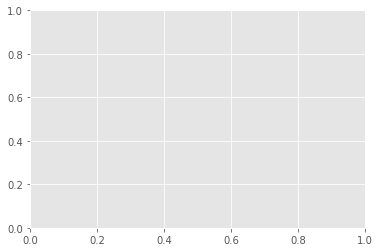

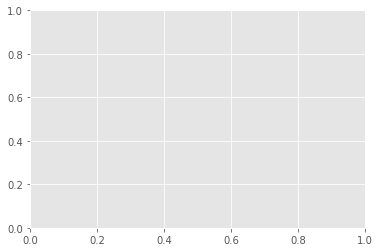

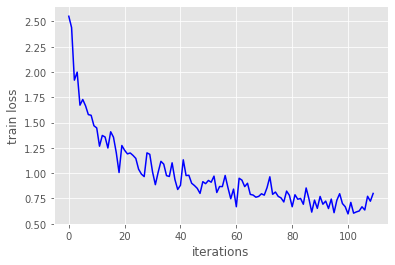

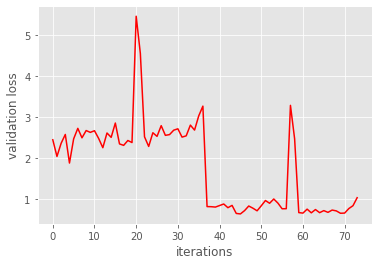

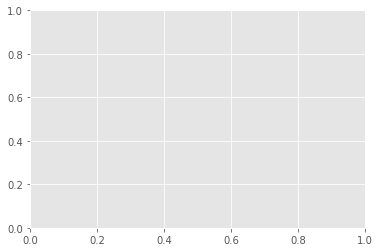

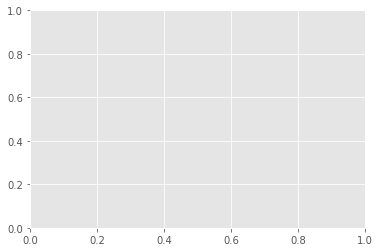

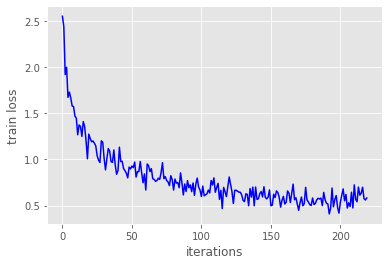

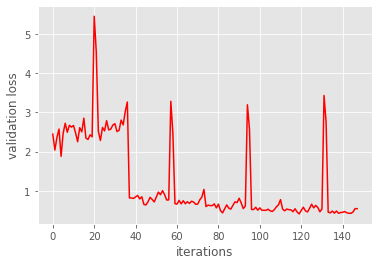

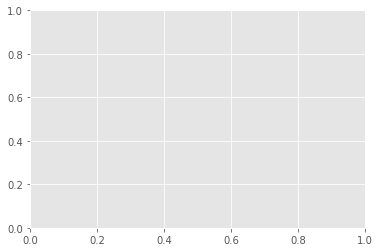

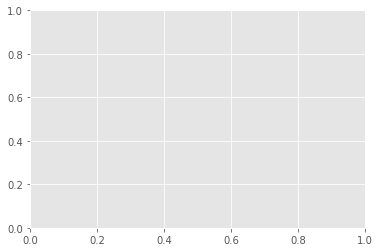

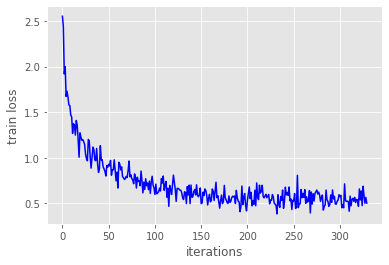

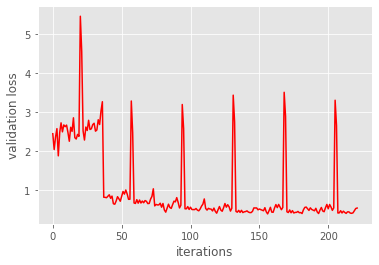

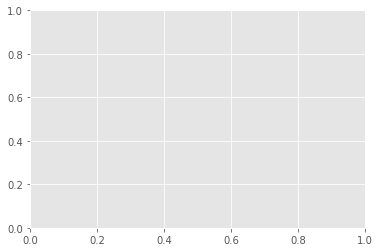

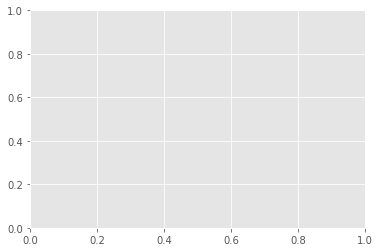

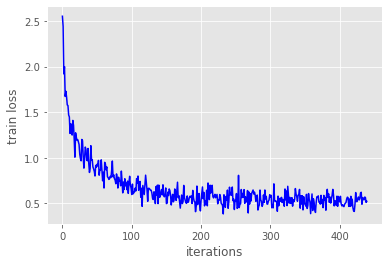

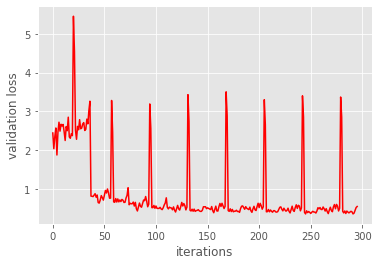

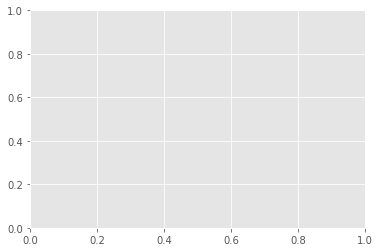

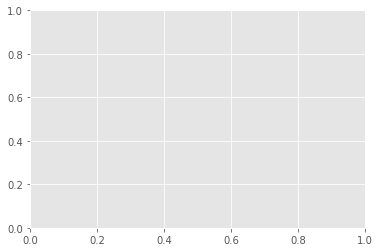

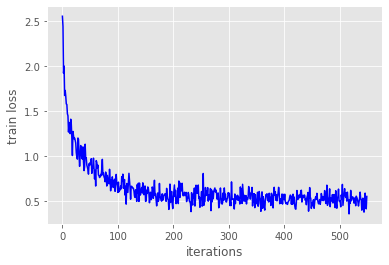

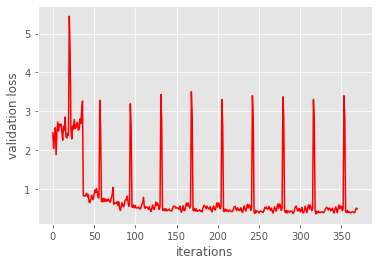

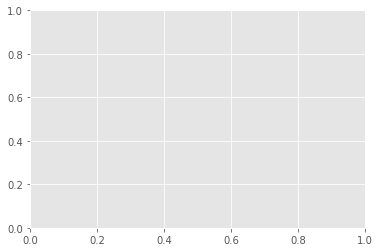

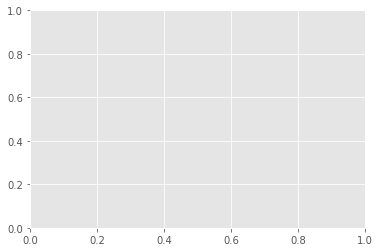

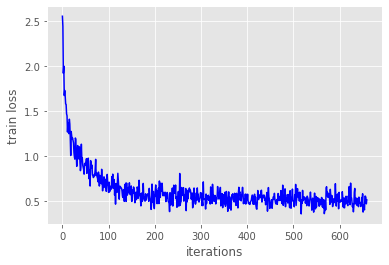

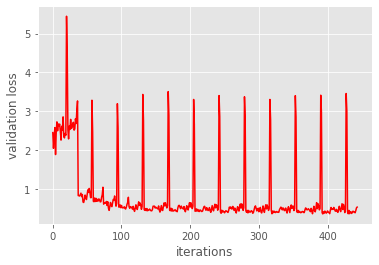

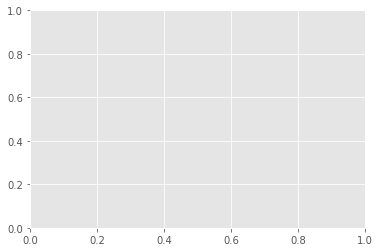

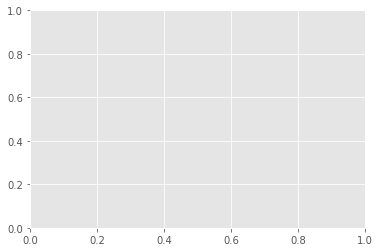

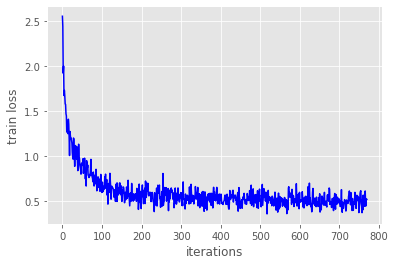

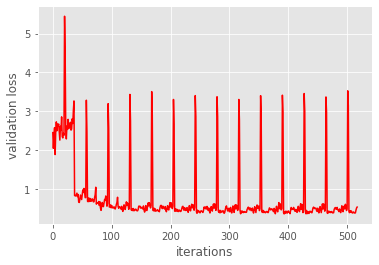

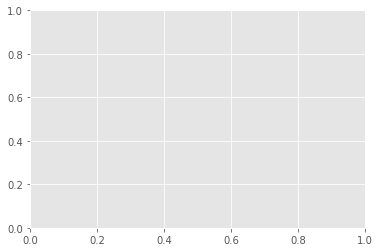

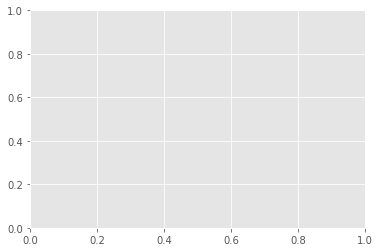

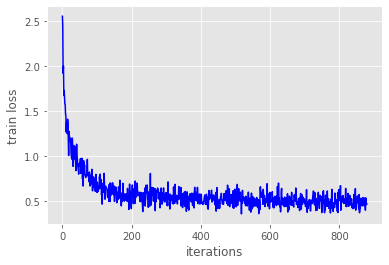

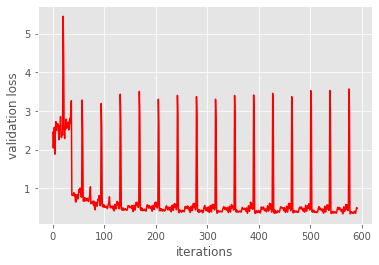

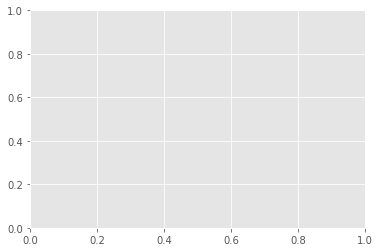

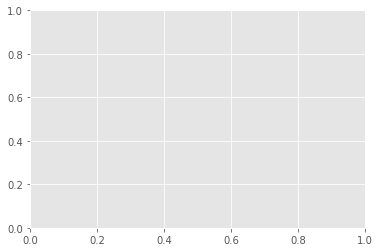

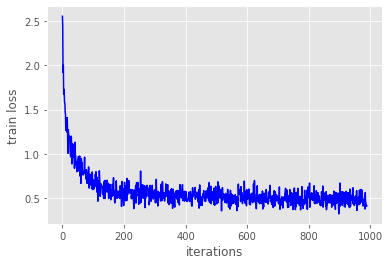

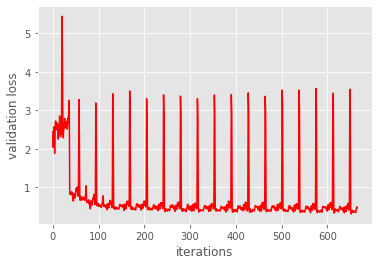

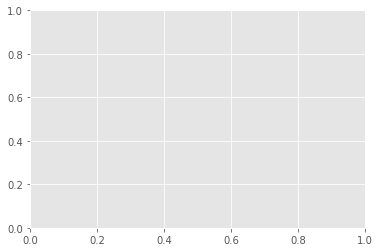

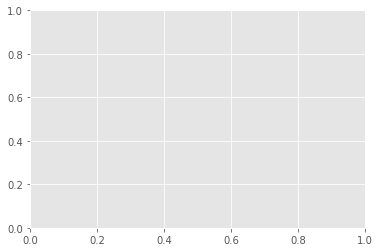

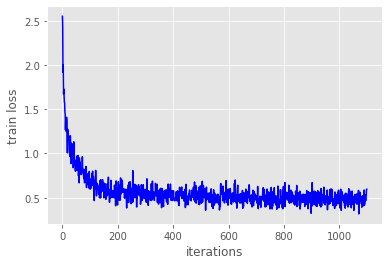

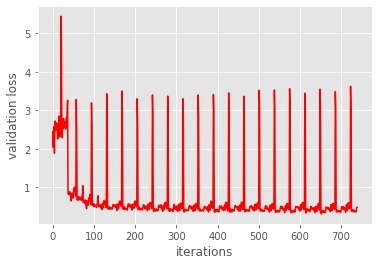

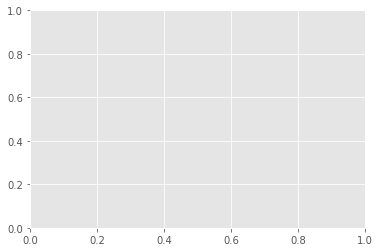

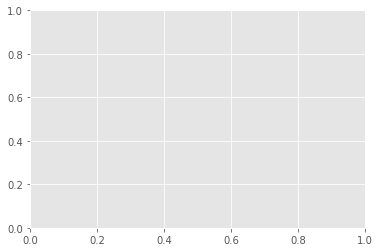

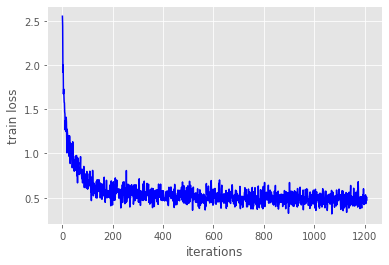

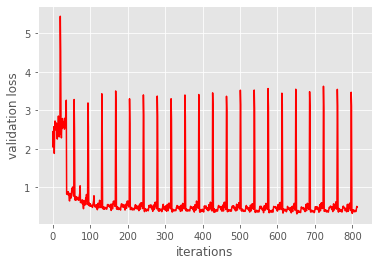

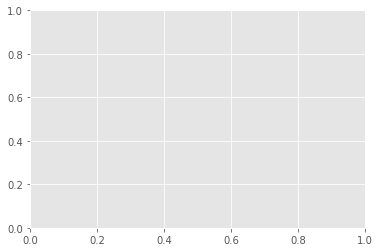

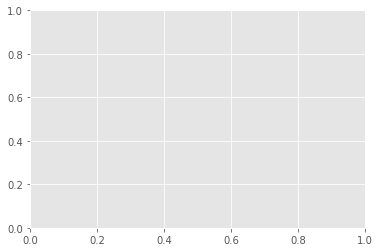

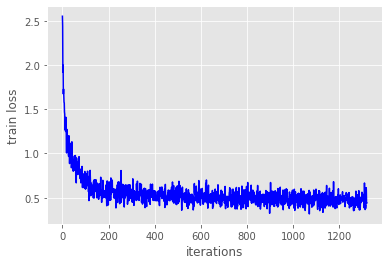

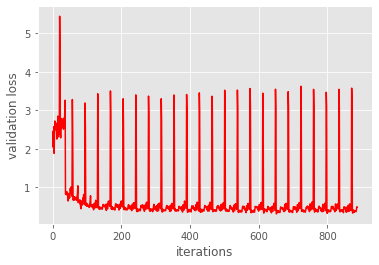

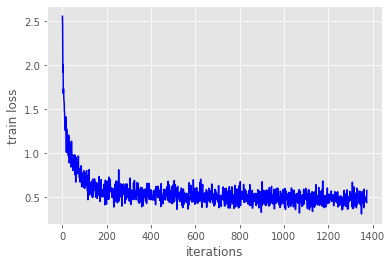

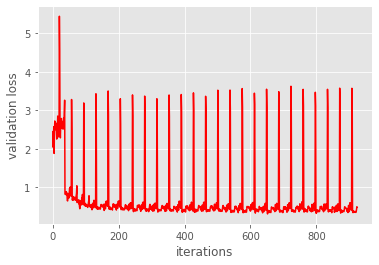

In [6]:
# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'
# whether to show transformed images from data loader or not
if VISUALIZE_TRANSFORMED_IMAGES:
    #from utils import show_tranformed_image
    show_tranformed_image(train_loader)
# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
   
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    # start timer and carry out training and validation
    start = time.time()
    val_loss = validate(valid_loader, model)
    train_loss = train(train_loader, model)

    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")


In [122]:
import numpy as np
import cv2
import torch
import glob as glob

model.eval()

DIR_TEST = VALID_DIR
test_images = glob.glob(f"{DIR_TEST}/*")
print(f"Test instances: {len(test_images)}")
# classes: 0 index is reserved for background
CLASSES = [
    'background', 'RBC', 'WBC', 'Platelets'
]
# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.8
test_images = ['//hd.ad.syr.edu/02/8fe522/Documents/Desktop/BCCD/test\\BloodImage_00251.jpg', '//hd.ad.syr.edu/02/8fe522/Documents/Desktop/BCCD/test\\BloodImage_00252.jpg', '//hd.ad.syr.edu/02/8fe522/Documents/Desktop/BCCD/test\\BloodImage_00253.jpg', '//hd.ad.syr.edu/02/8fe522/Documents/Desktop/BCCD/test\\BloodImage_00254.jpg']
results = []
for i in range(len(test_images)):
    # get the image file name for saving output later on
        
    image_name = test_images[i].split('/')[-1].split('.')[0]
    print(image_name)
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cpu()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        scores = scores[scores >= detection_threshold]
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            
            cv2.putText(orig_image, pred_classes[j] + ' ' + str(np.round(scores[j],2)), 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 
                        2, lineType=cv2.LINE_AA)
            
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (255, 0, 0), 2)
        s = cv2.imshow('Prediction', orig_image)
        results.append(orig_image)
        cv2.waitKey(1)
        cv2.imwrite("//hd.ad.syr.edu/02/8fe522/Documents/Desktop/outputs/{}.jpg".format(i), orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows()

Test instances: 290
test\BloodImage_00251


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Image 1 done...
--------------------------------------------------
test\BloodImage_00252
Image 2 done...
--------------------------------------------------
test\BloodImage_00253
Image 3 done...
--------------------------------------------------
test\BloodImage_00254
Image 4 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE
